# **Rodando Modelos: DBScan**

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from scipy import stats


In [20]:
df = pd.read_csv("C:/Users/gabri/OneDrive/Documents/Faculdade/2024.2/Projeto de Ciência de Dados/novo/volleyball-case-study/data/para-o-projeto/team_v_team.csv")
df.head()

,Unnamed: 0,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,...,Team B Hit Pct,Team B Assists,Team B Aces,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS
0,0,8302019,USC Upstate,Virginia Tech,0,4.0,33,21,112,0.107,...,0.234,48,13,12,51,4,4,20,2,0.0
1,1,8302019,USC Upstate,Northwestern,0,3.0,16,24,89,-0.090,...,0.349,41,6,7,42,1,2,20,0,0.0
2,2,9072019,USC Upstate,Ga. Southern,0,3.0,37,20,117,0.145,...,0.239,39,4,5,49,2,1,6,1,50.0
3,3,9132019,USC Upstate,Norfolk St.,1,5.0,50,27,164,0.140,...,0.114,47,11,15,67,9,1,17,1,70.5
4,4,9142019,USC Upstate,George Washington,0,3.0,30,17,112,0.116,...,0.216,44,3,1,60,2,1,6,6,52.0


In [21]:
columns_team_A = ['Team A Kills', 'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
                  'Team A Assists', 'Team A Aces', 'Team A SErr', 'Team A Digs', 'Team A RErr',
                  'Team A Block Solos', 'Team A Block Assists', 'Team A BErr', 'Team A PTS']

columns_team_B = ['Team B Kills', 'Team B Errors', 'Team B Total Attacks', 'Team B Hit Pct',
                  'Team B Assists', 'Team B Aces', 'Team B SErr', 'Team B Digs', 'Team B RErr',
                  'Team B Block Solos', 'Team B Block Assists', 'Team B BErr', 'Team B PTS']

In [22]:
df['duplicata_id'] = df.apply(lambda row: f"{row['Date']}_{row['TeamB']}_{row['TeamA']}", axis=1)

# Identificar os registros que não têm duplicatas
missing_duplicates = ~df['duplicata_id'].isin(df.apply(lambda row: f"{row['Date']}_{row['TeamA']}_{row['TeamB']}", axis=1))

# Selecionar os registros que não têm duplicatas
df_missing_duplicates = df[missing_duplicates].copy()

# Criar as duplicatas invertendo Team A e Team B e suas estatísticas
df_missing_duplicates['TeamA'], df_missing_duplicates['TeamB'] = df_missing_duplicates['TeamB'], df_missing_duplicates['TeamA']

# Inverter as estatísticas entre Team A e Team B
df_missing_duplicates[columns_team_A], df_missing_duplicates[columns_team_B] = df_missing_duplicates[columns_team_B].values, df_missing_duplicates[columns_team_A].values

# Remover a coluna 'duplicata_id' das duplicatas criadas
df_missing_duplicates = df_missing_duplicates.drop(columns=['duplicata_id'])

# Adicionar as duplicatas ao DataFrame original
df_combined = pd.concat([df, df_missing_duplicates])

df_combined.drop(columns=['duplicata_id'])
df = df_combined.drop(columns=['duplicata_id'])

In [23]:
def format_date(date):
    date_str = str(date)  # Converte o inteiro para string
    if len(date_str) == 7:  # Caso a data tenha 7 caracteres (mês ou dia com um único dígito)
        return pd.to_datetime(date_str, format='%m%d%Y')
    else:
        return pd.to_datetime(date_str, format='%m%d%Y')

# Aplicar a função de formatação às datas
df['Date'] = df['Date'].apply(format_date)
df = df.drop(columns=["Unnamed: 0"])

In [24]:
# Criando um dicionário para mapear os IDs dos times
team_ids = {team: idx for idx, team in enumerate(set(df["TeamA"]).union(df["TeamB"]))}

# Adicionando colunas de IDs de time
df["TeamA_ID"] = df["TeamA"].map(team_ids)
df["TeamB_ID"] = df["TeamB"].map(team_ids)

# Criando a coluna de ID da partida, garantindo que os jogos reversos tenham o mesmo ID
df["Match_ID"] = df.apply(lambda row: (row["Date"], tuple(sorted([row["TeamA_ID"], row["TeamB_ID"]]))), axis=1)

# Convertendo a combinação (data, time A ID, time B ID) em um identificador numérico único
df["Match_ID"] = df["Match_ID"].apply(lambda x: hash(x))

df.head()

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,33.0,21.0,112.0,0.107,30.0,...,12.0,51.0,4.0,4.0,20.0,2.0,0.0,305,46,2050982646294672498
1,2019-08-30,USC Upstate,Northwestern,0,3.0,16.0,24.0,89.0,-0.090,15.0,...,7.0,42.0,1.0,2.0,20.0,0.0,0.0,305,153,-478731068498954831
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,37.0,20.0,117.0,0.145,35.0,...,5.0,49.0,2.0,1.0,6.0,1.0,50.0,305,229,7993941589102485123
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,50.0,27.0,164.0,0.140,47.0,...,15.0,67.0,9.0,1.0,17.0,1.0,70.5,305,245,-7910218197301323186
4,2019-09-14,USC Upstate,George Washington,0,3.0,30.0,17.0,112.0,0.116,30.0,...,1.0,60.0,2.0,1.0,6.0,6.0,52.0,305,221,-4167127398243726202


### **Verificando Distribuição dos Dados em Relação a Normal**

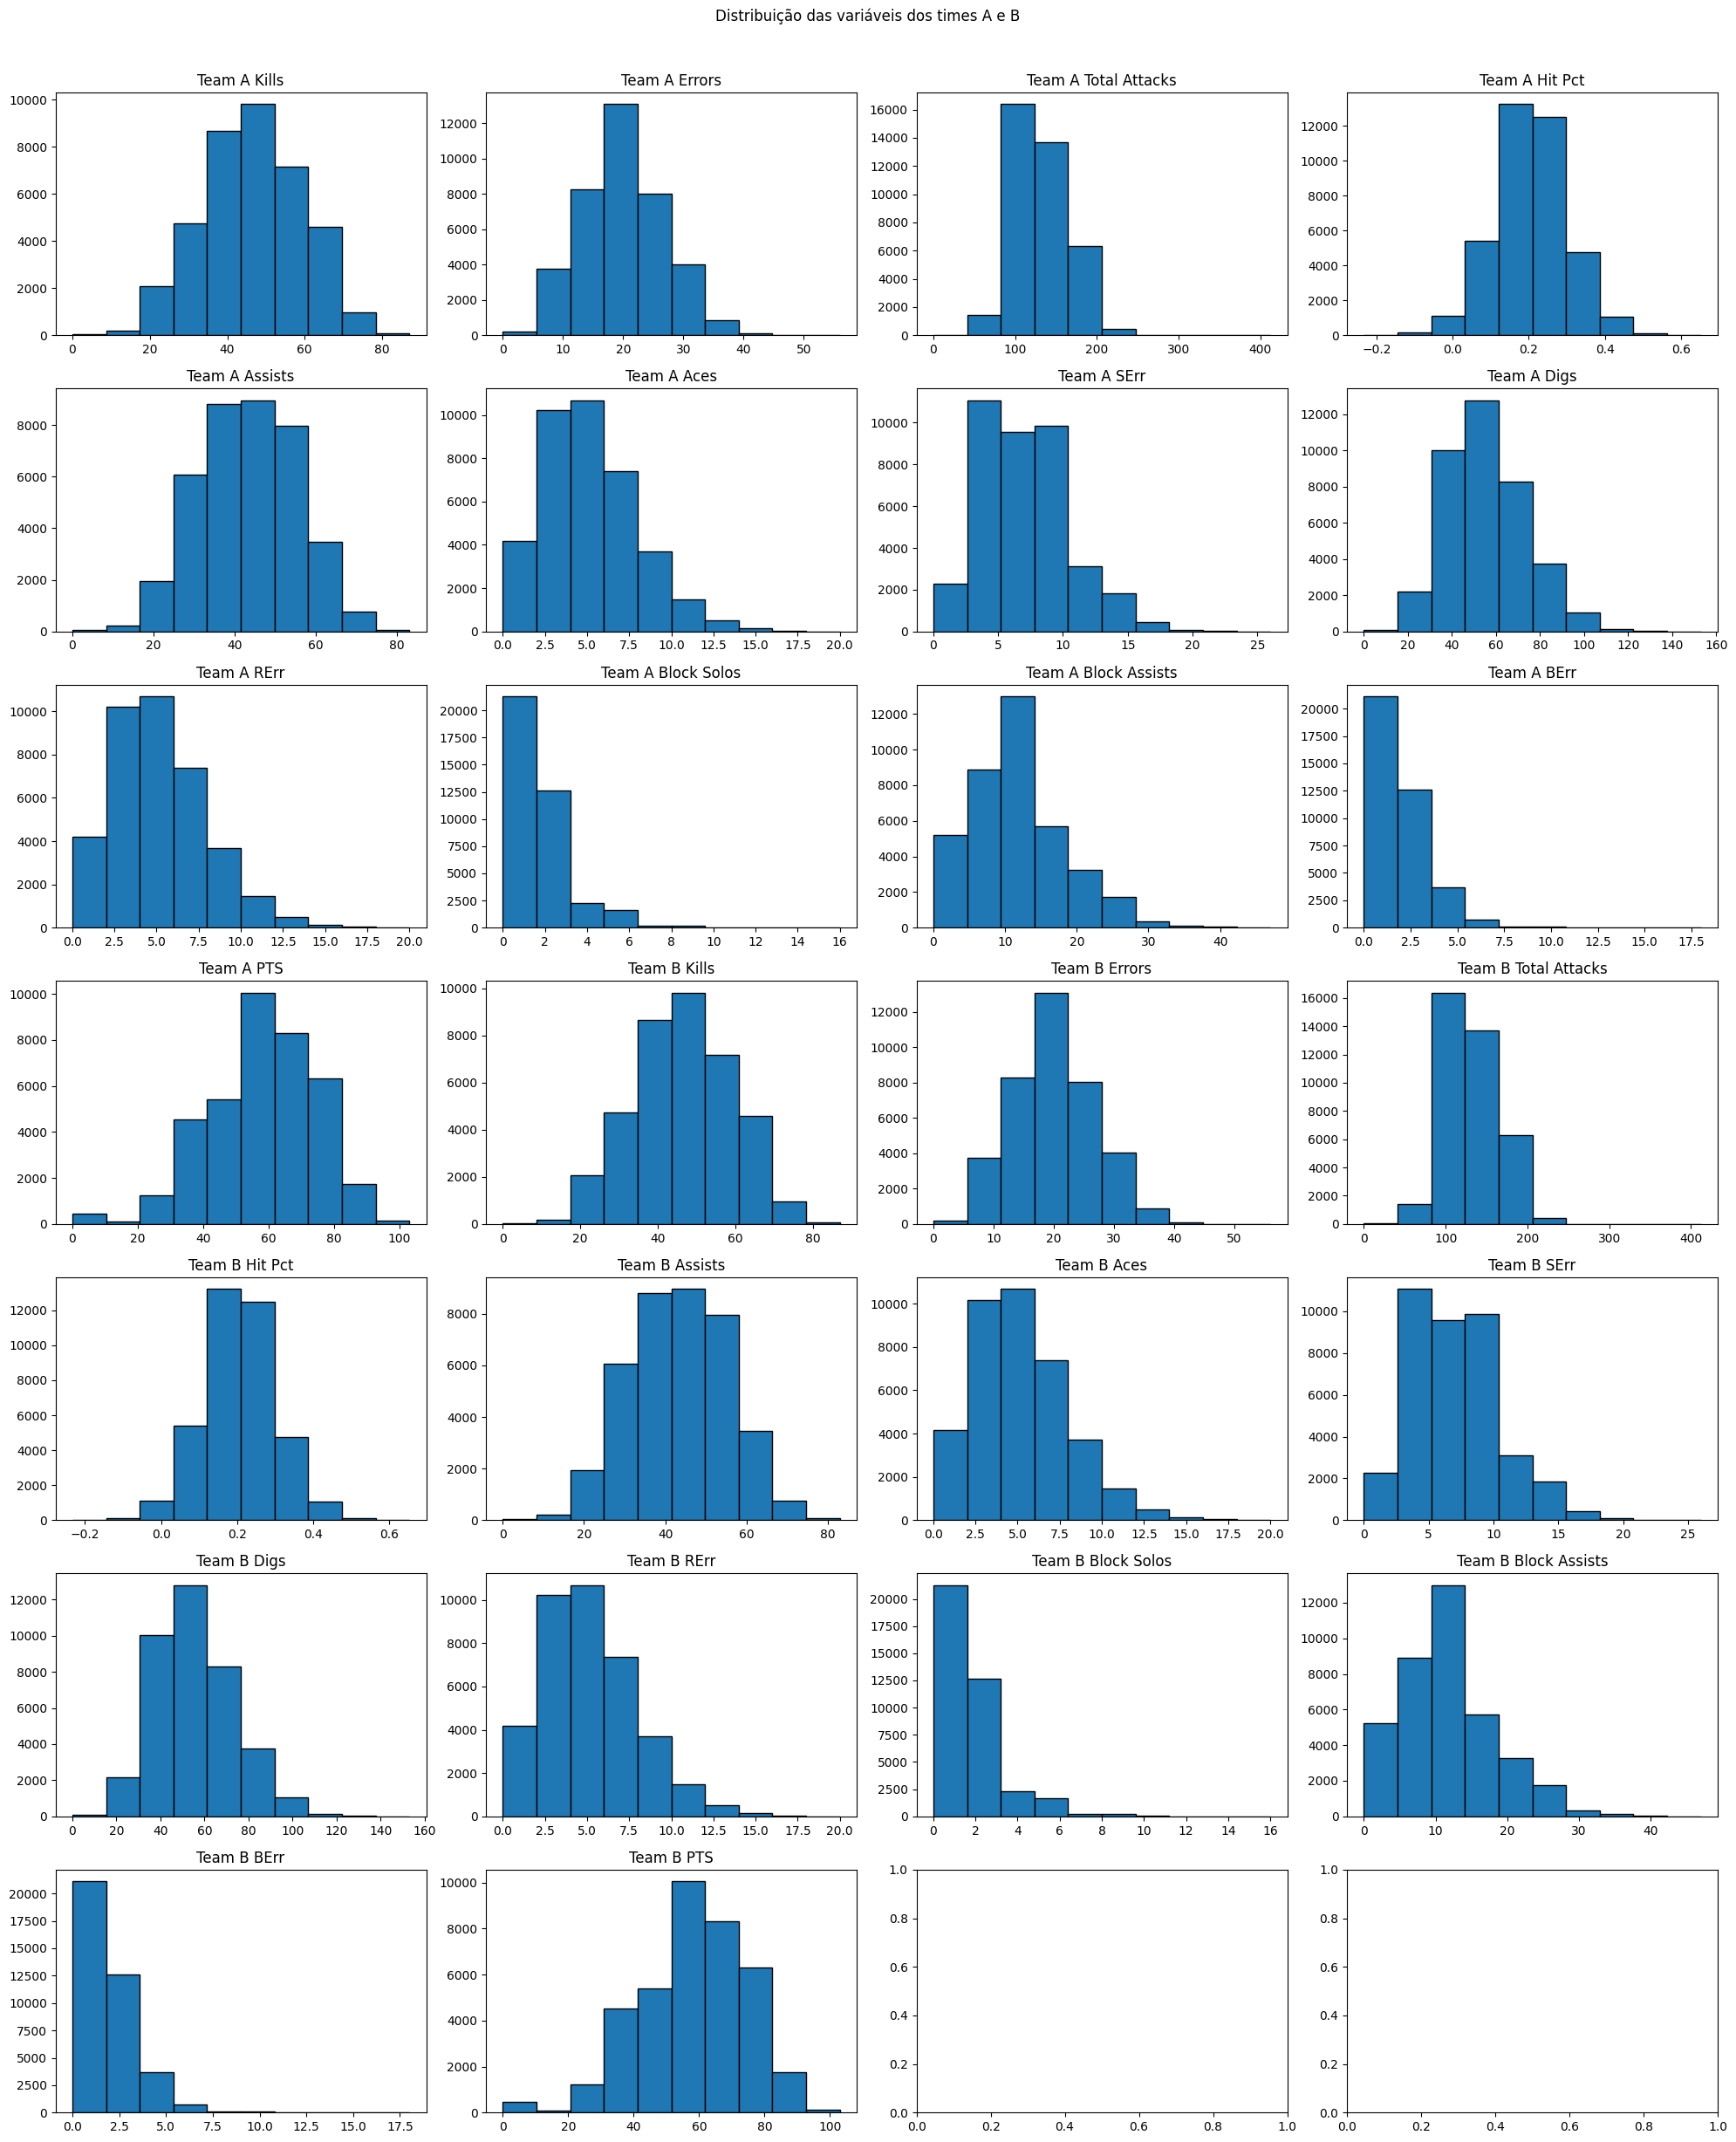

In [13]:
fig, axs = plt.subplots(7, 4, figsize=(20, 25))
fig.suptitle('Distribuição das variáveis dos times A e B')

colunas = df.columns

colunas_verify = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists', 'Team A Aces', 'Team A SErr', 'Team A Digs',
       'Team A RErr', 'Team A Block Solos', 'Team A Block Assists',
       'Team A BErr', 'Team A PTS', 'Team B Kills', 'Team B Errors',
       'Team B Total Attacks', 'Team B Hit Pct', 'Team B Assists',
       'Team B Aces', 'Team B SErr', 'Team B Digs', 'Team B RErr',
       'Team B Block Solos', 'Team B Block Assists', 'Team B BErr',
       'Team B PTS']

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    axs[i].hist(df[col], bins=10, edgecolor='black')
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### **Normalização**

In [25]:
scaler = MinMaxScaler()
df_norm = df
df_norm[colunas_verify] = scaler.fit_transform(df[colunas_verify])
df_norm.head()

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,0.379310,0.375000,0.271845,0.384181,0.361446,...,0.461538,0.333333,0.20,0.2500,0.425532,0.111111,0.000000,305,46,2050982646294672498
1,2019-08-30,USC Upstate,Northwestern,0,3.0,0.183908,0.428571,0.216019,0.161582,0.180723,...,0.269231,0.274510,0.05,0.1250,0.425532,0.000000,0.000000,305,153,-478731068498954831
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.425287,0.357143,0.283981,0.427119,0.421687,...,0.192308,0.320261,0.10,0.0625,0.127660,0.055556,0.485437,305,229,7993941589102485123
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.574713,0.482143,0.398058,0.421469,0.566265,...,0.576923,0.437908,0.45,0.0625,0.361702,0.055556,0.684466,305,245,-7910218197301323186
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.344828,0.303571,0.271845,0.394350,0.361446,...,0.038462,0.392157,0.10,0.0625,0.127660,0.333333,0.504854,305,221,-4167127398243726202


### **Vericando Outliers**

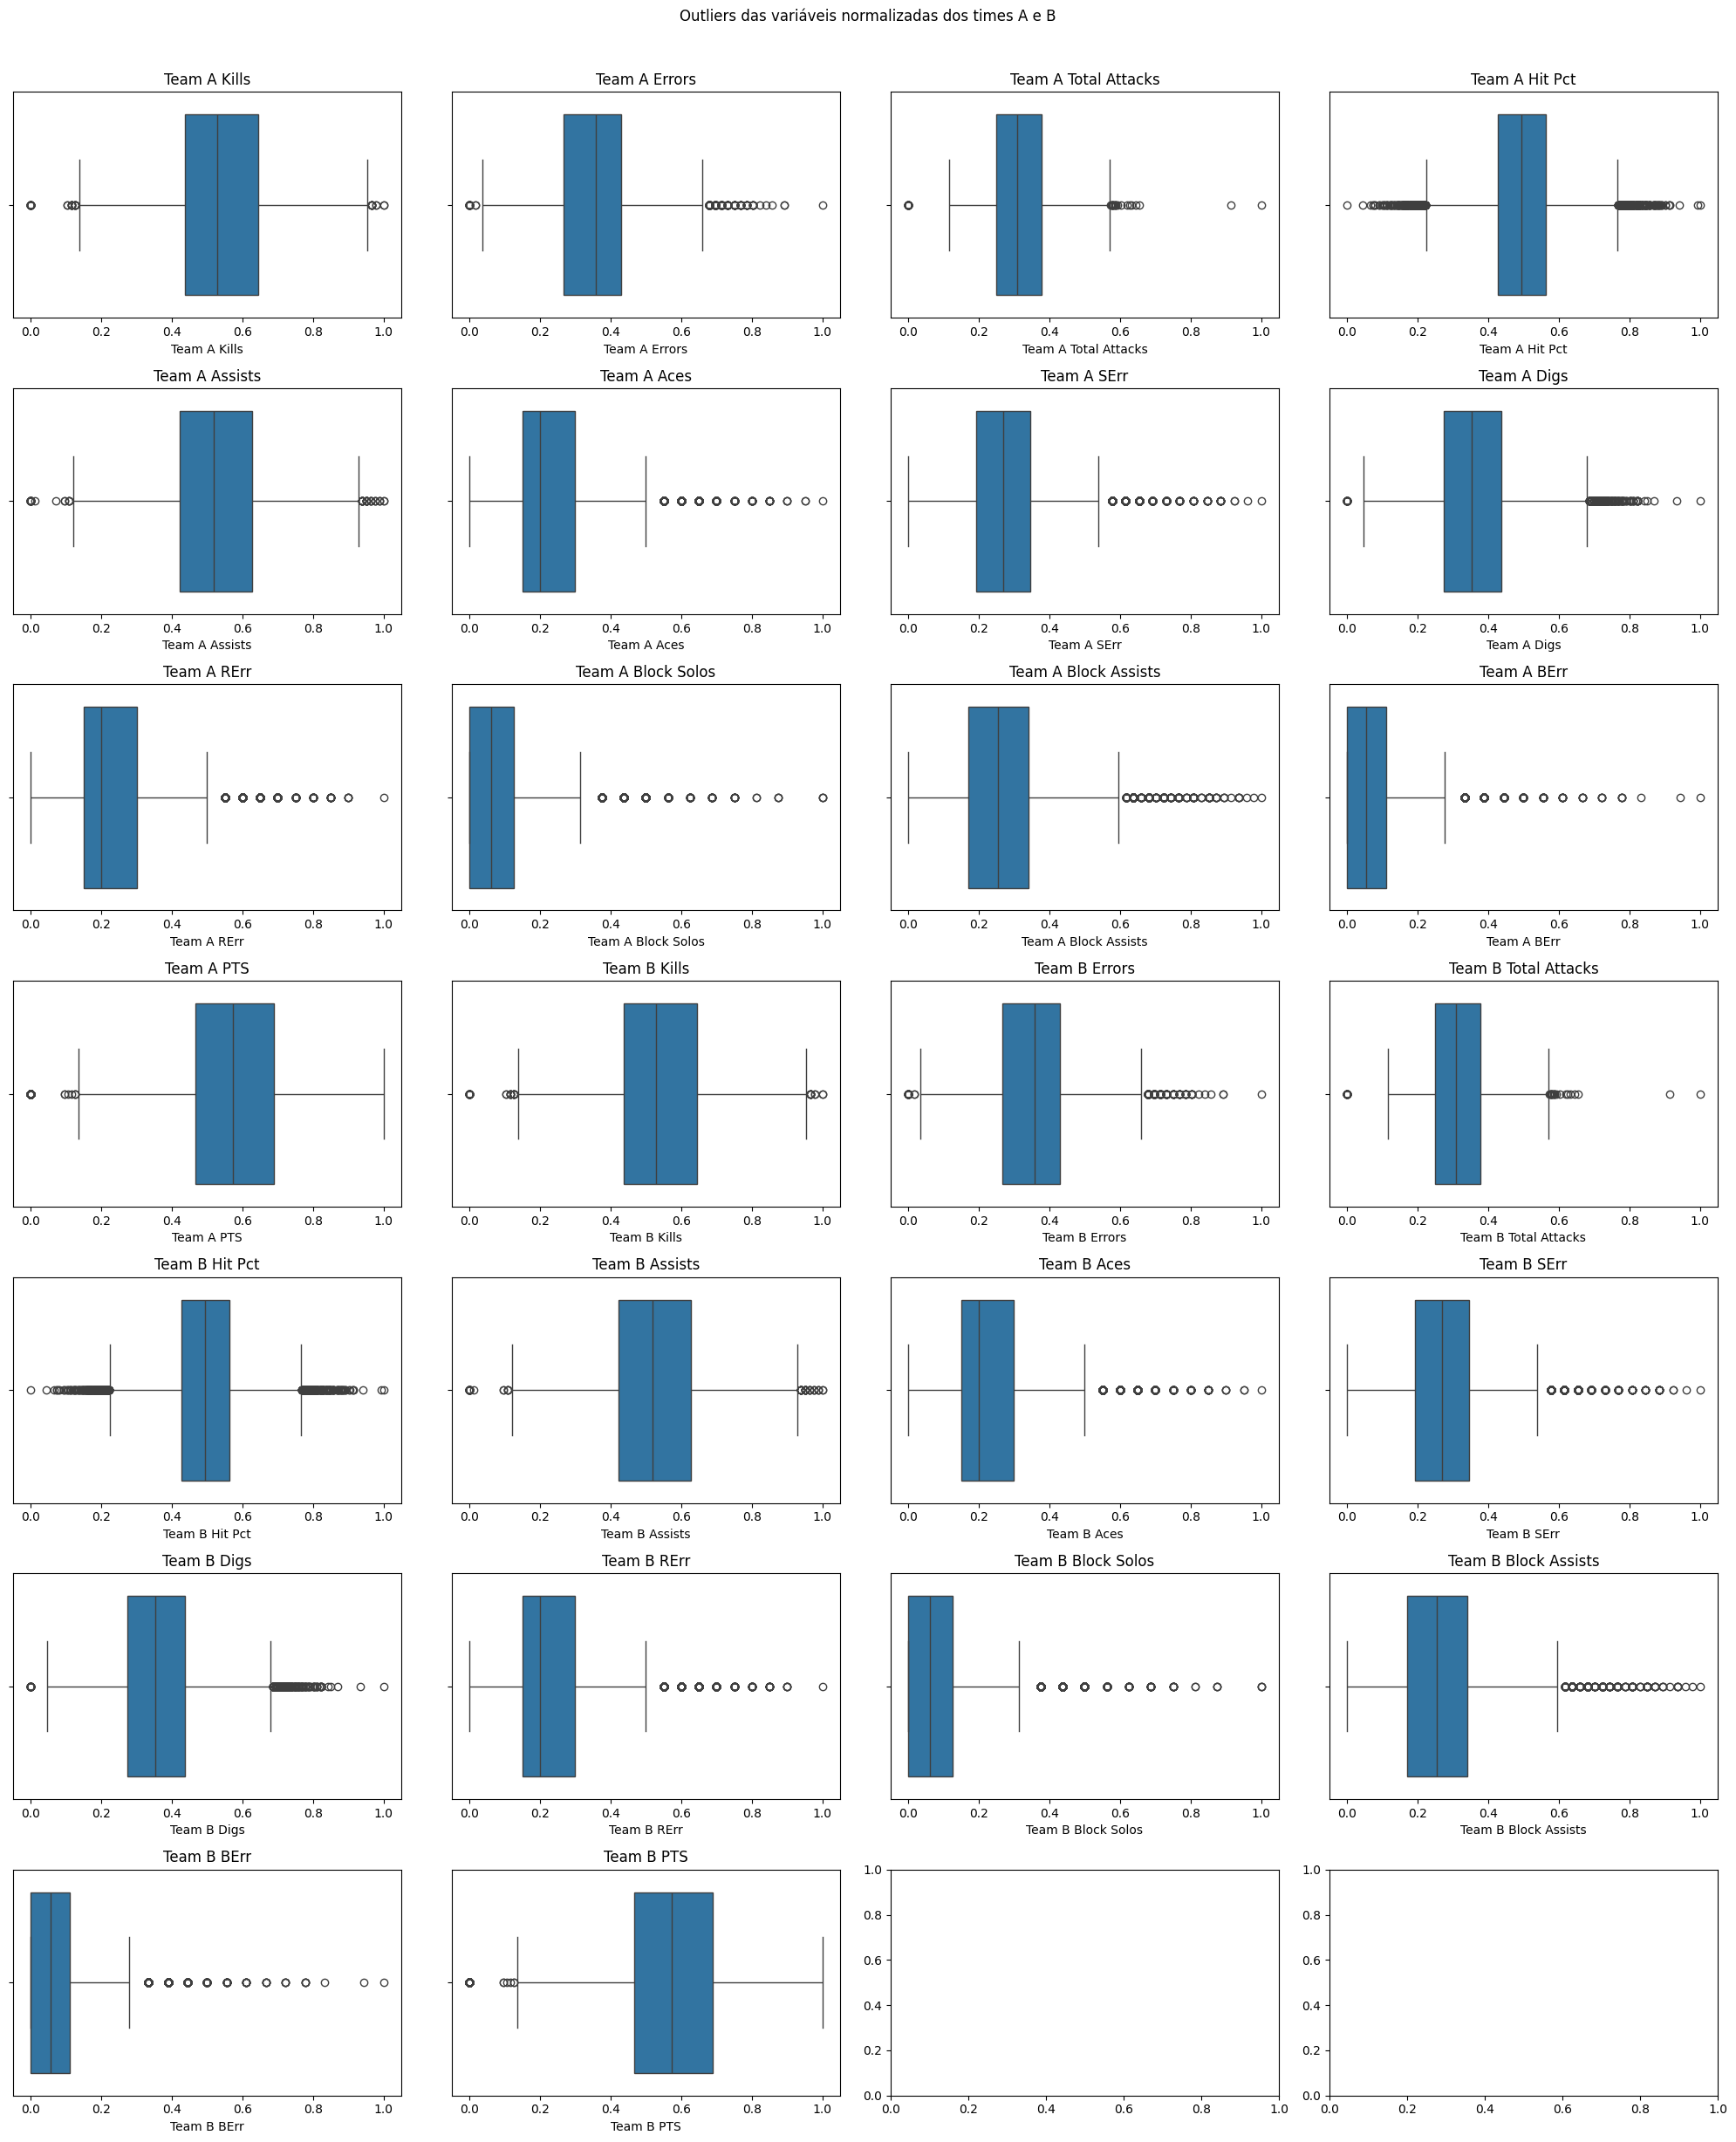

In [26]:
fig, axs = plt.subplots(7, 4, figsize=(20, 25))
fig.suptitle('Outliers das variáveis normalizadas dos times A e B')

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    sns.boxplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### **Retirada de Outliers via zscore**

In [27]:
z_scores = stats.zscore(df[colunas_verify])
df_norm_clean = df_norm[(abs(z_scores) < 3).all(axis=1)]

In [18]:
df_norm_clean.head()

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.425287,0.357143,0.283981,0.427119,0.421687,...,0.192308,0.320261,0.10,0.0625,0.127660,0.055556,0.485437,305,229,7993941589102485123
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.574713,0.482143,0.398058,0.421469,0.566265,...,0.576923,0.437908,0.45,0.0625,0.361702,0.055556,0.684466,305,245,-7910218197301323186
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.344828,0.303571,0.271845,0.394350,0.361446,...,0.038462,0.392157,0.10,0.0625,0.127660,0.333333,0.504854,305,221,-4167127398243726202
5,2019-09-14,USC Upstate,East Carolina,0,5.0,0.666667,0.392857,0.407767,0.505085,0.686747,...,0.192308,0.496732,0.30,0.1250,0.170213,0.222222,0.815534,305,146,8093435105858421287
6,2019-09-17,USC Upstate,N.C. A&T,1,4.0,0.655172,0.303571,0.313107,0.613559,0.602410,...,0.615385,0.307190,0.15,0.1250,0.234043,0.000000,0.684466,305,43,-8085587068052216235


## **Divisão de Features**
Divisão realizada baseado na apresentação utilizada de base sobre estatísticas de vôlei

OBS: Estou analisando aqui ainda, quais colunas do time B por

**Gerais**
* Date
* Team A/ID
* Team B/ID
* Result
* S
* Match ID

**Ataque**
* Team A Kills: Número de ataques que resultaram em pontos
* Team A Errors: Erros de ataque cometidos
* Team A Total Attacks: Total de ataques realizados
* Team A Hit Pct: Percentual de acerto no ataque
* Team A Assists: Assistências para ataque

**Saque**
* Team A Aces: Pontos diretos de saque
* Team A SErr: Erros de saque

**Defesa**
* Team A Digs: Defesas bem-sucedidas
* Team A RErr: Erros de recepção

**Bloqueio**
* Team A Block Solos: Bloqueios individuais
* Team A Block Assists: Assistências em bloqueios
* Team A BErr: Erros de bloqueio

### **Dividindo Dataframe pelas categorias**

In [28]:
# Ataque
colunas_atq = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists']
df_atq = df_norm_clean[colunas_atq]
correlation_matrix_atq = df_atq.corr()

# Saque
colunas_saq = ['Team A Aces', 'Team A SErr']
df_saq = df_norm_clean[colunas_saq]
correlation_matrix_saq = df_saq.corr()

# Defesa
colunas_def = ['Team A Digs', 'Team A RErr']
df_def = df_norm_clean [colunas_def]
correlation_matrix_def = df_def.corr()

#Bloqueio
colunas_bloq = ['Team A Block Solos', 'Team A Block Assists', 'Team A BErr']
df_bloq = df_norm_clean [colunas_bloq]
correlation_matrix_bloq = df_bloq.corr()

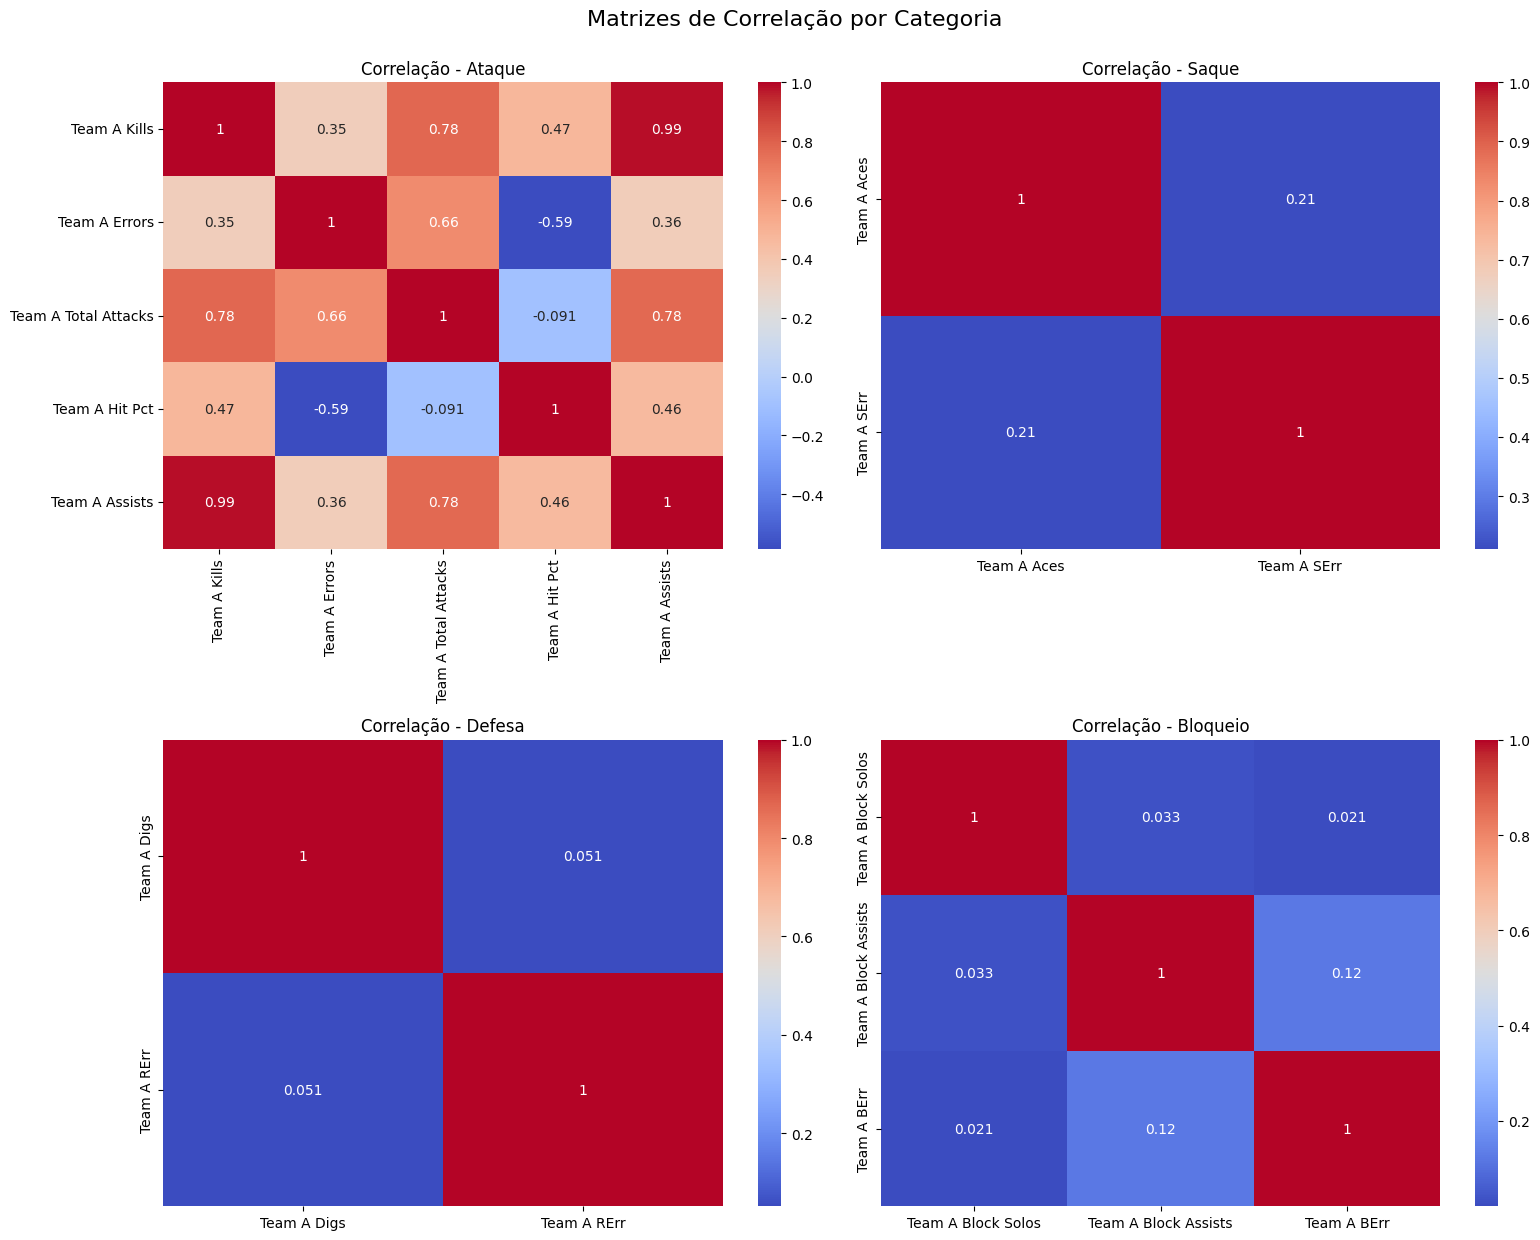

In [29]:
# Criando a figura com 2 linhas e 2 colunas de subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plotando o heatmap para Ataque
sns.heatmap(correlation_matrix_atq, annot=True, cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Correlação - Ataque')

# Plotando o heatmap para Saque
sns.heatmap(correlation_matrix_saq, annot=True, cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Correlação - Saque')

# Plotando o heatmap para Defesa
sns.heatmap(correlation_matrix_def, annot=True, cmap='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Correlação - Defesa')

# Plotando o heatmap para Bloqueio
sns.heatmap(correlation_matrix_bloq, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlação - Bloqueio')

# Ajustando o layout para melhorar a visualização
plt.tight_layout()

# Adicionando o título geral da figura
fig.suptitle('Matrizes de Correlação por Categoria', fontsize=16, y=1.03)

# Exibindo a figura
plt.show()


### **Retirando Colunas com Alta Correlação**

In [30]:
df_atq = df_atq.drop(columns=['Team A Assists'])

In [31]:
df_atq.head()

,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct
2,0.425287,0.357143,0.283981,0.427119
3,0.574713,0.482143,0.398058,0.421469
4,0.344828,0.303571,0.271845,0.394350
5,0.666667,0.392857,0.407767,0.505085
6,0.655172,0.303571,0.313107,0.613559


In [32]:
df_saq.head()

,Team A Aces,Team A SErr
2,0.10,0.153846
3,0.45,0.230769
4,0.10,0.230769
5,0.30,0.230769
6,0.15,0.384615


In [33]:
df_def.head()

,Team A Digs,Team A RErr
2,0.313725,0.20
3,0.496732,0.55
4,0.274510,0.15
5,0.418301,0.40
6,0.352941,0.40


In [34]:
df_bloq.head()

,Team A Block Solos,Team A Block Assists,Team A BErr
2,0.2500,0.042553,0.111111
3,0.1250,0.425532,0.000000
4,0.0000,0.255319,0.000000
5,0.0625,0.276596,0.055556
6,0.0000,0.425532,0.000000


### **Teste Preliminar: DBSCAN**

In [35]:
def dbscan_categoria(df):

    eps_values = [0.01,0.02,0.03,0.04,0.05,0.09]
    min_samples = 5
    
    silhouette = []
    davies_bouldin = []

    for eps in eps_values:

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df)

        silhouette.append((eps, silhouette_score(df, labels)))
        davies_bouldin.append((eps, davies_bouldin_score(df, labels)))


    return davies_bouldin, silhouette

**DBSCAN para Ataque**

In [ ]:
db_atq, sl_atq = dbscan_categoria(df_atq)
atq = {'Categoria': 'Ataque','Silhouette-Score':sl_atq,'Davies-Bouldin-Score':db_atq,}

**DBSCAN para Bloqueio**

In [53]:
db_bloq, sl_bloq = dbscan_categoria(df_bloq)
bloq = {'Categoria': 'Bloqueio','Silhouette-Score':sl_bloq,'Davies-Bouldin-Score':db_bloq,}


**DBSCAN para Defesa**

In [54]:
db_def, sl_def = dbscan_categoria(df_def)
de = {'Categoria': 'Defesa','Silhouette-Score':sl_def,'Davies-Bouldin-Score':db_def}

**DBSCAN para Saque**

In [55]:
db_saq, sl_saq = dbscan_categoria(df_saq)
saq = {'Categoria': 'Saque','Silhouette-Score':sl_saq,'Davies-Bouldin-Score':db_saq}

#### **Análise de Resultados**

In [56]:
dados = []
casos = [saq, de, atq, bloq]

for caso in casos:
    for sl_tupla, db_tupla in zip(caso['Silhouette-Score'], caso['Davies-Bouldin-Score']):
        n_clusters = sl_tupla[0]
        sl_score = sl_tupla[1]
        db_score = db_tupla[1]


        dados.append({
            'Categoria': caso['Categoria'],
            'n eps': n_clusters,
            'Silhouette Score': sl_score,
            'Davies-Bouldin Score': db_score,
        })

resultados = pd.DataFrame(dados)
resultados

,Categoria,n eps,Silhouette Score,Davies-Bouldin Score
0,Saque,0.01,0.998259,0.959948
1,Saque,0.02,0.998259,0.959948
2,Saque,0.03,0.998259,0.959948
3,Saque,0.04,0.873669,0.190475
4,Saque,0.05,0.873669,0.190475
5,Saque,0.09,0.873669,0.190475
6,Defesa,0.01,0.789132,2.359085
7,Defesa,0.02,0.869304,3.560667
8,Defesa,0.03,0.872863,4.338715
9,Defesa,0.04,0.879769,0.173759


Como é importante analisar visualmente se os clusters ficaram bem dividos, deixei para decidir quais os melhores parâmetros depois de visualizar os scatters plots

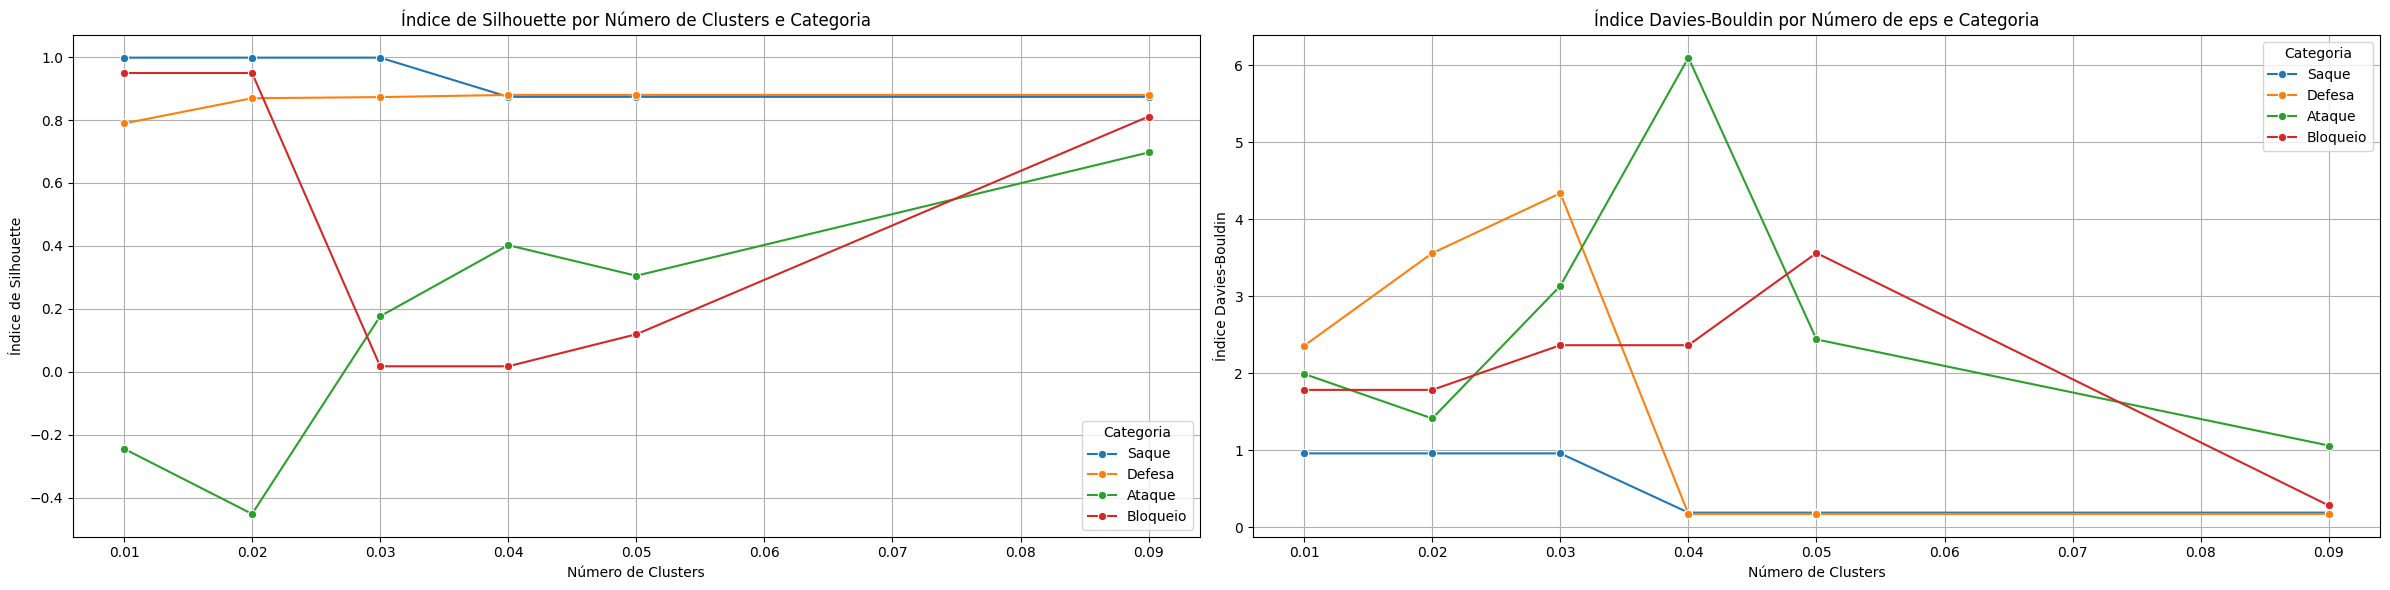

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Gráfico de Silhouette
sns.lineplot(x='n eps', y='Silhouette Score', hue='Categoria', marker='o', data=resultados, ax=axes[0])
axes[0].set_title('Índice de Silhouette por Número de Clusters e Categoria')
axes[0].set_xlabel('Número de Clusters')
axes[0].set_ylabel('Índice de Silhouette')
axes[0].legend(title='Categoria')
axes[0].grid(True)

# Gráfico de Davies-Bouldin
sns.lineplot(x='n eps', y='Davies-Bouldin Score', hue='Categoria', marker='o', data=resultados, ax=axes[1])
axes[1].set_title('Índice Davies-Bouldin por Número de eps e Categoria')
axes[1].set_xlabel('Número de Clusters')
axes[1].set_ylabel('Índice Davies-Bouldin')
axes[1].legend(title='Categoria')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### **Visualização Gráfica**

In [123]:
# Ataque
df_atq_cluster = df_atq
dbscan = DBSCAN(eps=0.09, min_samples=5)
df_atq_cluster['Cluster'] = dbscan.fit_predict(df_atq_cluster[['Team A Kills', 'Team A Errors']])

# Bloqueio
df_bloq_cluster = df_bloq
dbscan = DBSCAN(eps=0.050, min_samples=10)
df_bloq_cluster['Cluster'] = dbscan.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])

# Defesa
df_def_cluster = df_def
dbscan = DBSCAN(eps=0.040, min_samples=5)
df_def_cluster['Cluster'] = dbscan.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])

# Saque
df_saq_cluster = df_saq
dbscan = DBSCAN(eps=0.03855, min_samples=8)
df_saq_cluster['Cluster'] = dbscan.fit_predict(df_saq_cluster[['Team A Aces', 'Team A SErr']])

C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\1237751530.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bloq_cluster['Cluster'] = dbscan.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])
C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\1237751530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_def_cluster['Cluster'] = dbscan.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])
C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\1237751530.py:19: SettingWithCopyW

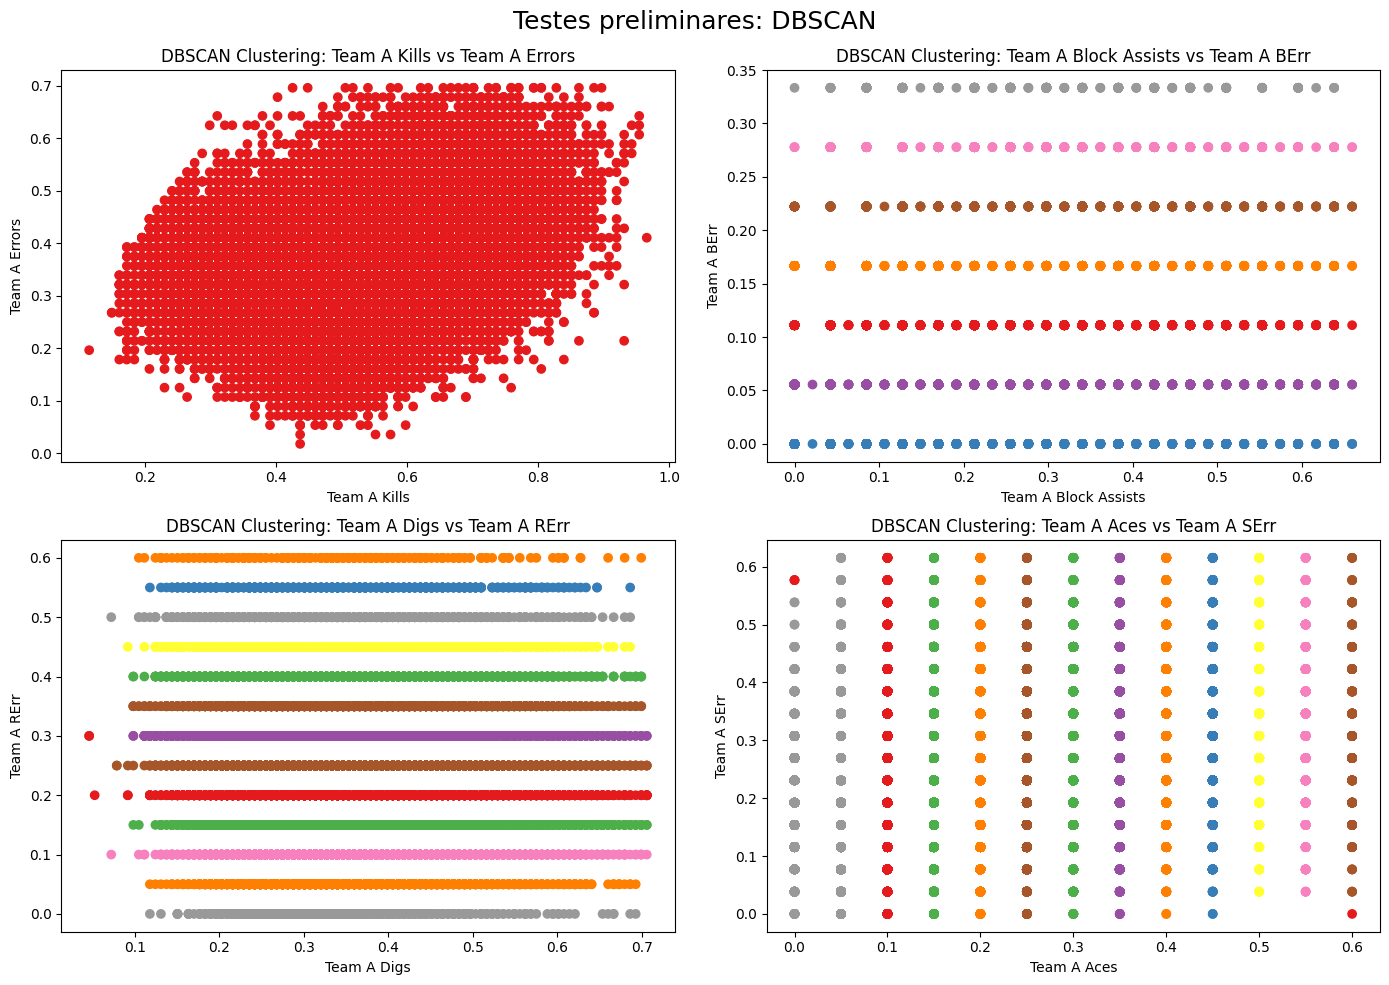

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico Ataque
axes[0, 0].scatter(df_atq_cluster['Team A Kills'], df_atq_cluster['Team A Errors'], 
                   c=df_atq_cluster['Cluster'], cmap='Set1')
axes[0, 0].set_xlabel('Team A Kills')
axes[0, 0].set_ylabel('Team A Errors')
axes[0, 0].set_title('DBSCAN Clustering: Team A Kills vs Team A Errors')

# Gráfico Bloqueio
axes[0, 1].scatter(df_bloq_cluster['Team A Block Assists'], df_bloq_cluster['Team A BErr'], 
                   c=df_bloq_cluster['Cluster'], cmap='Set1')
axes[0, 1].set_xlabel('Team A Block Assists')
axes[0, 1].set_ylabel('Team A BErr')
axes[0, 1].set_title('DBSCAN Clustering: Team A Block Assists vs Team A BErr')

# Gráfico Defesa
axes[1, 0].scatter(df_def_cluster['Team A Digs'], df_def_cluster['Team A RErr'], 
                   c=df_def_cluster['Cluster'], cmap='Set1')
axes[1, 0].set_xlabel('Team A Digs')
axes[1, 0].set_ylabel('Team A RErr')
axes[1, 0].set_title('DBSCAN Clustering: Team A Digs vs Team A RErr')

# Gráfico Saque
axes[1, 1].scatter(df_saq_cluster['Team A Aces'], df_saq_cluster['Team A SErr'], 
                   c=df_saq_cluster['Cluster'], cmap='Set1')
axes[1, 1].set_xlabel('Team A Aces')
axes[1, 1].set_ylabel('Team A SErr')
axes[1, 1].set_title('DBSCAN Clustering: Team A Aces vs Team A SErr')

plt.tight_layout()
fig.suptitle('Testes preliminares: DBSCAN', fontsize=18)
plt.subplots_adjust(wspace=0.15, hspace=0.20,top=0.92)
plt.show()


### **Conclusões**

DBSCAN teve um ótimo resultado em Bloqueio, Defesa e saques o que já era previsto devido ao caráter vertical da distribuição dos dados

### **Analisando Porcentagem de Ganho de Partidas**

In [125]:
x = df_norm_clean

x['cl atq'] = df_atq_cluster['Cluster']
x['cl def'] = df_def_cluster['Cluster']
x['cl bloq'] = df_bloq_cluster['Cluster']
x['cl saq'] = df_saq_cluster['Cluster']

C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\2539744741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['cl atq'] = df_atq_cluster['Cluster']
C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\2539744741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['cl def'] = df_def_cluster['Cluster']
C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\2539744741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [126]:
duplicated_matches = x[x.duplicated(subset=['Match_ID'], keep=False)]

# Para cada Match_ID duplicado, pegar os valores do primeiro e do segundo registros
for match_id in duplicated_matches['Match_ID'].unique():
    # Filtrar os registros com o mesmo Match_ID
    same_match = x[x['Match_ID'] == match_id]
    
    # Pegar o primeiro e o segundo registros
    first_row_index = same_match.index[0]
    second_row_index = same_match.index[1]
    
    # Pegar os valores do segundo registro e adicionar ao primeiro com novos nomes
    x.loc[first_row_index, 'cl atq B'] = x.loc[second_row_index, 'cl atq']
    x.loc[first_row_index, 'cl def B'] = x.loc[second_row_index, 'cl def']
    x.loc[first_row_index, 'cl bloq B'] = x.loc[second_row_index, 'cl bloq']
    x.loc[first_row_index, 'cl saq B'] = x.loc[second_row_index, 'cl saq']
    
    # Pegar os valores do primeiro registro e adicionar ao segundo com novos nomes
    x.loc[second_row_index, 'cl atq B'] = x.loc[first_row_index, 'cl atq']
    x.loc[second_row_index, 'cl def B'] = x.loc[first_row_index, 'cl def']
    x.loc[second_row_index, 'cl bloq B'] = x.loc[first_row_index, 'cl bloq']
    x.loc[second_row_index, 'cl saq B'] = x.loc[first_row_index, 'cl saq']

In [127]:
def calcula_aproveitamento(n,col,x):
    lst = {}
    for i in range(n):
        so_i = x[(x[col] == i)]

        for j in range(n):
            df_ij = so_i[so_i[f'{col} B'] == j]
            df_ij
            total_partidas = df_ij.shape[0]
            if total_partidas != 0:
                df_ij_vit = df_ij[df_ij['Result']==1]
                total_vitorias = df_ij_vit.shape[0]
                lst[f'{i}x{j}'] = total_vitorias/total_partidas
            else:
                print(f'para {i} e {j} total de partidas deu 0 no cluster de {col}')
    return lst

apv_atq = calcula_aproveitamento(2,'cl atq',x)
apv_bloq = calcula_aproveitamento(7,'cl bloq',x)
apv_saq = calcula_aproveitamento(13,'cl saq',x)
apv_def = calcula_aproveitamento(13,'cl def',x)

para 0 e 1 total de partidas deu 0 no cluster de cl atq
para 1 e 0 total de partidas deu 0 no cluster de cl atq
para 1 e 1 total de partidas deu 0 no cluster de cl atq


#### **Porcentagem de Vitórias por Matchup**

In [128]:
heatmap_atq = pd.DataFrame(index=[0, 1, 2], columns=[0, 1, 2])
for key, value in apv_atq.items():
    i, j = map(int, key.split('x'))
    heatmap_atq.at[i, j] = value
heatmap_atq = heatmap_atq.astype(float)

heatmap_bloq = pd.DataFrame(index=[0, 1], columns=[0, 1])
for key, value in apv_bloq.items():
    i, j = map(int, key.split('x'))
    heatmap_bloq.at[i, j] = value
heatmap_bloq = heatmap_bloq.astype(float)

heatmap_def = pd.DataFrame(index=[0, 1], columns=[0, 1])
for key, value in apv_def.items():
    i, j = map(int, key.split('x'))
    heatmap_def.at[i, j] = value
heatmap_def = heatmap_def.astype(float)

heatmap_saq = pd.DataFrame(index=[0, 1], columns=[0, 1])
for key, value in apv_saq.items():
    i, j = map(int, key.split('x'))
    heatmap_saq.at[i, j] = value
heatmap_saq = heatmap_saq.astype(float)

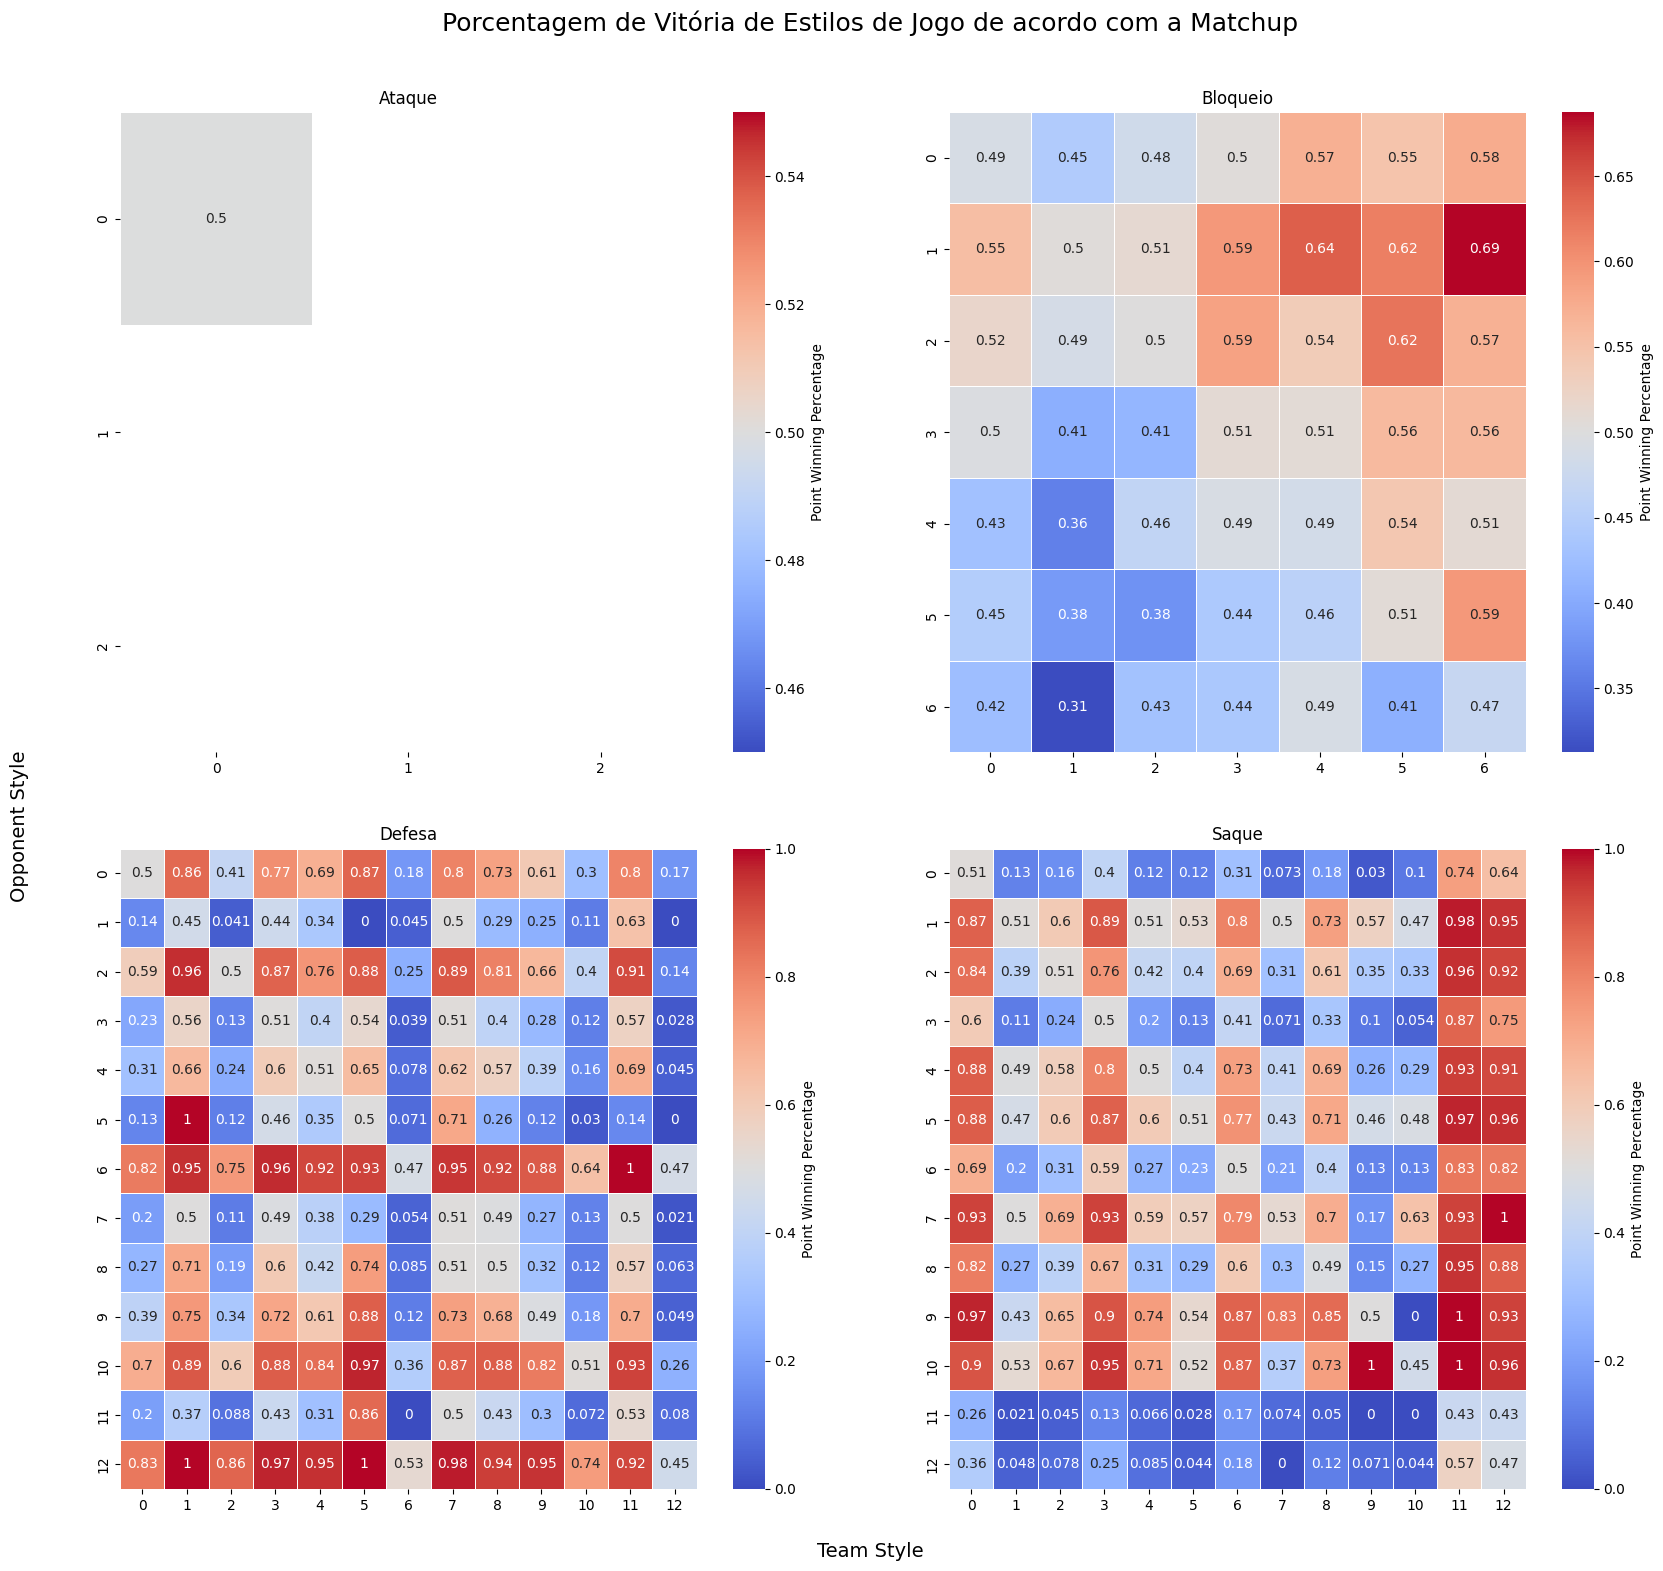

In [129]:
fig, axes = plt.subplots(2, 2, figsize=(20, 17))

sns.heatmap(heatmap_atq, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[0, 0])
sns.heatmap(heatmap_bloq, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[0, 1])
sns.heatmap(heatmap_def, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[1, 0])
sns.heatmap(heatmap_saq, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[1, 1])

axes[0, 0].set_title('Ataque')
axes[0, 1].set_title('Bloqueio')
axes[1, 0].set_title('Defesa')
axes[1, 1].set_title('Saque')

fig.text(0.5, 0.07, 'Team Style', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'Opponent Style', va='center', rotation='vertical', fontsize=14)

fig.suptitle('Porcentagem de Vitória de Estilos de Jogo de acordo com a Matchup', fontsize=18)

plt.subplots_adjust(wspace=0.15, hspace=0.15,top=0.92)

plt.show()

## **Estilos Completos**

### **Porcentagem de Vitória por Matchup de Estilos Completos**

In [130]:
x['Estilo Completo'] = x.apply(lambda row: f"{row['cl atq']}{row['cl def']}{row['cl bloq']}{row['cl saq']}", axis=1)
x = x.dropna(subset=['cl def B'])
x['Estilo Completo B'] = x.apply(lambda row: f"{int(row['cl atq B'])}{int(row['cl def B'])}{int(row['cl bloq B'])}{int(row['cl saq B'])}", axis=1)


C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\3607141849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Estilo Completo'] = x.apply(lambda row: f"{row['cl atq']}{row['cl def']}{row['cl bloq']}{row['cl saq']}", axis=1)
C:\Users\gabri\AppData\Local\Temp\ipykernel_31348\3607141849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Estilo Completo B'] = x.apply(lambda row: f"{int(row['cl atq B'])}{int(row['cl def B'])}{int(row['cl bloq B'])}{int(row['cl saq B'])}", axis=1)


In [131]:
df_unique = x.drop_duplicates(subset='Match_ID', keep='first')

resultado_agrupado = x.groupby(['Estilo Completo', 'Estilo Completo B']).agg(
    total_partidas=('Result', 'size'),
    total_vitorias=('Result', 'sum')
).reset_index()

# Calcular a porcentagem de vitórias
resultado_agrupado['porcentagem_vitorias'] = (resultado_agrupado['total_vitorias'] / resultado_agrupado['total_partidas'])
resultado_agrupado

,Estilo Completo,Estilo Completo B,total_partidas,total_vitorias,porcentagem_vitorias
0,0-120,01024,1,0,0.000000
1,0-126,0022,1,0,0.000000
2,0000,0000,4,0,0.000000
3,0000,01006,25,9,0.360000
4,0000,01016,35,9,0.257143
...,...,...,...,...,...
5567,0966,0068,1,1,1.000000
5568,0967,01148,1,0,0.000000
5569,0968,0928,2,0,0.000000
5570,0968,0938,2,1,0.500000


In [132]:
resultado_agrupado = resultado_agrupado.sort_values(by='porcentagem_vitorias', ascending=False)
resultado_agrupado = resultado_agrupado.sort_values(by='total_partidas', ascending=False)
pt=resultado_agrupado

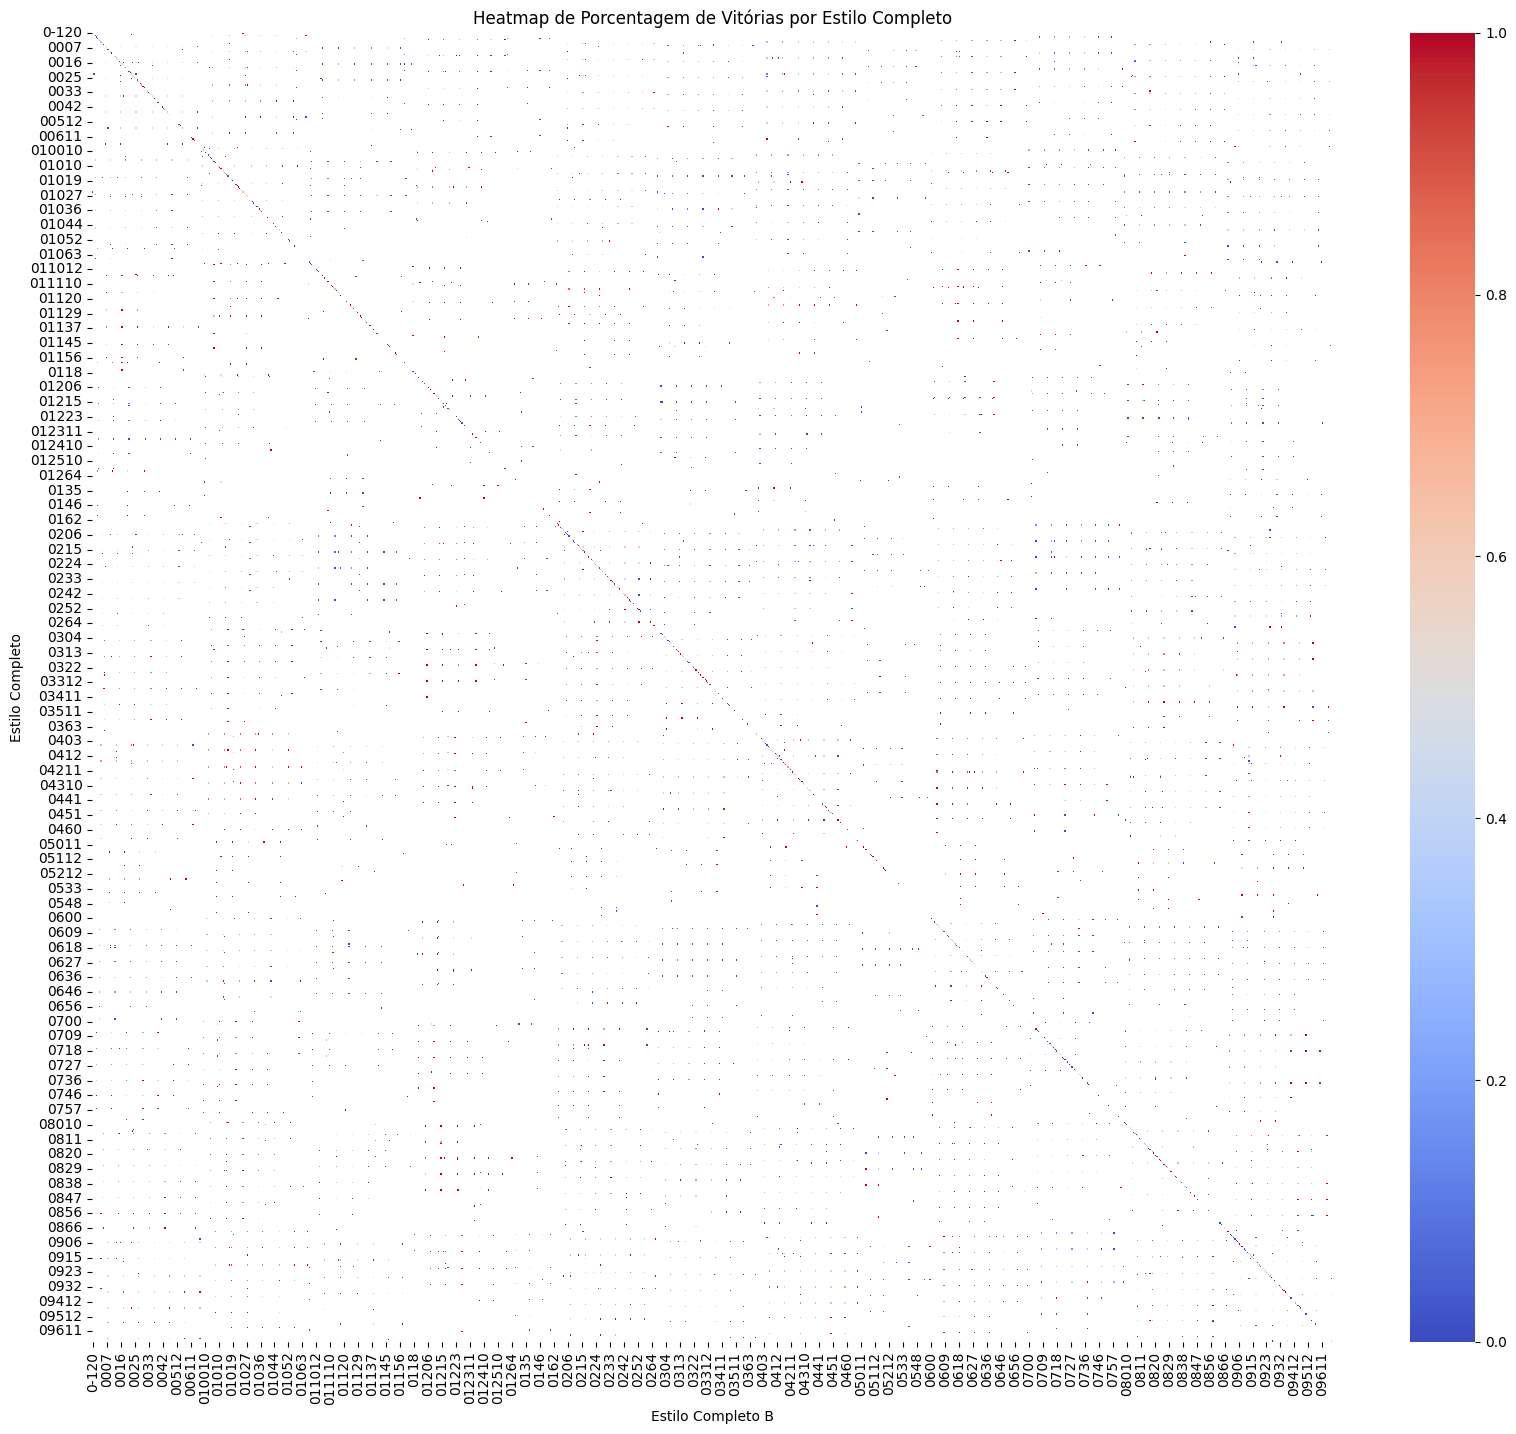

In [133]:
heatmap_data = pt.pivot(index="Estilo Completo B", columns="Estilo Completo", values="porcentagem_vitorias")

plt.figure(figsize=(20, 17))
sns.heatmap(heatmap_data, cmap="coolwarm")
plt.title("Heatmap de Porcentagem de Vitórias por Estilo Completo")
plt.xlabel("Estilo Completo B")
plt.ylabel("Estilo Completo")
plt.show()

Por conta da alta quantidade de estilos completos e da alta quantidade de estilos que não se enfrentaram, a análise de qualquer padrão por meio desse gráfico é bem difícil

### **Total de Vitóras por Estilo Completo**

In [134]:
df_A = resultado_agrupado.groupby('Estilo Completo').agg(
    total_partidas_A=('total_partidas', 'sum'),
    total_vitorias_A=('total_vitorias', 'sum')
).reset_index()

# 2. Criar DataFrame onde Estilo Completo B é 'Team B'
df_B = resultado_agrupado.groupby('Estilo Completo B').agg(
    total_partidas_B=('total_partidas', 'sum'),
    total_vitorias_B=('total_vitorias', 'sum')
).reset_index()

# Renomear a coluna para combinar com 'Estilo Completo'
df_B = df_B.rename(columns={'Estilo Completo B': 'Estilo Completo'})

# 3. Combinar os resultados de Team A e Team B
df_total = pd.merge(df_A, df_B, on='Estilo Completo', how='outer').fillna(0)

# 4. Calcular o total de partidas e vitórias para cada estilo completo
df_A['total_partidas'] = df_A['total_partidas_A']
df_A['total_vitorias'] = df_A['total_vitorias_A']
# 5. Calcular a porcentagem total de vitórias
df_A['porcentagem_vitorias_total'] = (df_A['total_vitorias'] / df_A['total_partidas']) * 100

# Selecionar as colunas finais desejadas
df_resultado_final = df_A[['Estilo Completo', 'total_partidas', 'total_vitorias', 'porcentagem_vitorias_total']]
df_resultado_final = df_resultado_final.sort_values(by='porcentagem_vitorias_total', ascending=False)
df_resultado_final[df_resultado_final['total_partidas']> 50].head(10)

,Estilo Completo,total_partidas,total_vitorias,porcentagem_vitorias_total
741,0615,52,51,98.076923
116,01015,76,73,96.052632
738,0612,106,101,95.283019
115,01014,111,104,93.693694
725,0602,59,54,91.525424
740,0614,98,89,90.816327
751,0622,92,83,90.217391
727,0604,60,54,90.000000
129,01024,119,107,89.915966
753,0624,67,60,89.552239
